In [8]:
import torch

## STEP 1. 데이터 모으기

In [9]:
# case 1
N=20
random0=torch.randn(int(N/2),1)
random5=torch.randn(int(N/2),1)+5
class1_data=torch.hstack([random0,random5])
class2_data=torch.hstack([random5,random0])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
X=torch.vstack([class1_data,class2_data])
y=torch.vstack([class1_label,class2_label])

# case 2
N=100
radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)
theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
class1_data=torch.hstack([radius1*torch.cos(theta1), radius1*torch.sin(theta1)])
class2_data=torch.hstack([radius2*torch.cos(theta2), radius2*torch.sin(theta2)])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
X=torch.vstack([class1_data,class2_data])
y=torch.vstack([class1_label,class2_label])

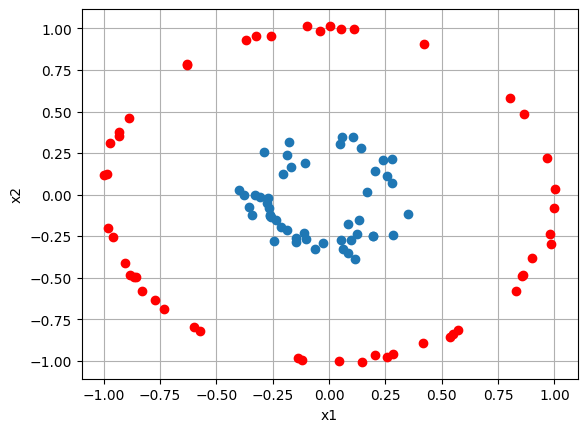

In [10]:
import matplotlib.pyplot as plt
plt.plot(class1_data[:,0],class1_data[:,1],'o')
plt.plot(class2_data[:,0],class2_data[:,1],'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

## STEP 2. 모델 만들기

In [11]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # case 1, plain
        self.linear = nn.Sequential(nn.Linear(2, 100), # 10,100,1000,10000 으로 바꿔보면서서 확인
                                    nn.Sigmoid(),
                                    nn.Linear(100, 1), # node가 많을수록 좋게 나옴
                                    nn.Sigmoid())
        # case 1, very simple
        self.linear = nn.Sequential(nn.Linear(2, 1), # 아주 simple 한 것도 오히려 갠춘
                                    nn.Sigmoid())
        # case 1, deep
        self.linear = nn.Sequential(nn.Linear(2, 100), # deep 하면 오래 걸림 (adam으로 바꾸면 해결 (작은 gradient면 분모가 작아져서 쭉쭉 나아감)) vanishing gradient랑 좀 다른 문제인 것 같다
                                    nn.Sigmoid(),
                                    nn.Linear(100, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())

        # case 2, plain
        self.linear = nn.Sequential(nn.Linear(2, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())
        # case 2, very simple
        self.linear = nn.Sequential(nn.Linear(2, 1), # 선형 분류만 가능해서 불가
                                    nn.Sigmoid())
        # case 2, deep
        self.linear = nn.Sequential(nn.Linear(2, 100), # LR을 줄이니까 수렴
                                    nn.Sigmoid(),
                                    nn.Linear(100, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())
        # case 2, very deep
        self.linear = nn.Sequential(nn.Linear(2, 100),
                                    nn.Sigmoid(),
                                    *[i for _ in range(10) for i in [nn.Linear(100, 100), nn.Sigmoid()]],
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())
        # case 2, very deep relu
        self.linear = nn.Sequential(nn.Linear(2, 100),
                                    nn.ReLU(),
                                    *[i for _ in range(10) for i in [nn.Linear(100, 100), nn.ReLU()]],
                                    nn.Linear(100, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        x = self.linear(x)
        return x

In [12]:
# nn.Sequential(*[nn.Sequential(nn.Linear(100,100), nn.Sigmoid()) for _ in range(10)])
# nn.Sequential(*[nn.Linear(100,100) if i % 2 == 0 else nn.Sigmoid() for i in range(20)])
# nn.Sequential(*[i for _ in range(10) for i in [nn.Linear(100,100), nn.Sigmoid()]])

In [13]:
model = MLP()
print(model)
print(model(torch.randn(5,2)).shape) # 2개 값으로 이루어진 좌표값 (x1,x2) 데이터 5개를 입력함

MLP(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=100, bias=True)
    (19): ReLU()
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ReLU()
    (22): Linear(in_features=100, out_features=1, bias=True)
    (23): Sigmoid()
  )
)
torch.Size([5, 1

## STEP 3. 모델 학습시키기

In [14]:
from torch import optim
# !pip install torchviz # 내 필기용
# from torchviz import make_dot # 내 필기용

# LR = 1e-1 # case 1
# LR = 1e-2 # case 2, plain 에서 노드 천 개, deep
LR = 1e-4 # case 2, very deep relu
# EPOCH = 100 # case 1
EPOCH = 500 # case 2, plain 에서 노드 천 개, deep, very deep relu

# optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=LR) # case 1, deep
# optimizer = optim.Adam(model.parameters(), lr=LR, eps=0, betas=(0.9, 0.99)) # 내 필기용
# optimizer = optim.Adam(model.parameters(), lr=LR, eps=1e-12, betas=(0.1, 0.1)) # 내 필기용
criterion = nn.BCELoss()

loss_history=[]
grad_history=[] # 내 필기용
update_size_history=[] # 내 필기용

model.train() # train mode로 전환
for ep in range(EPOCH):
    # inference
    y_hat = model(X)
    # loss
    loss = criterion(y_hat, y)
    # prev weights # 내 필기용
    prev=model.linear[0].weight.detach().clone() # 내 필기용
    # update
    optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
    loss.backward() # backpropagation
    optimizer.step() # weight update
    # update amount # 내 필기용
    grad_history += [ torch.sum(torch.abs( model.linear[0].weight.grad )).item() ] # 내 필기용
    update_size_history += [ torch.sum(torch.abs( model.linear[0].weight.detach() - prev)).item() ] # 내 필기용
    # print loss
    loss_history += [loss.item()]
    print(f"Epoch: {ep+1}, train loss: {loss.item():.4f}")
    print("-"*20)

Epoch: 1, train loss: 0.6959
--------------------
Epoch: 2, train loss: 0.6958
--------------------
Epoch: 3, train loss: 0.6957
--------------------
Epoch: 4, train loss: 0.6957
--------------------
Epoch: 5, train loss: 0.6956
--------------------
Epoch: 6, train loss: 0.6955
--------------------
Epoch: 7, train loss: 0.6954
--------------------
Epoch: 8, train loss: 0.6953
--------------------
Epoch: 9, train loss: 0.6953
--------------------
Epoch: 10, train loss: 0.6952
--------------------
Epoch: 11, train loss: 0.6951
--------------------
Epoch: 12, train loss: 0.6951
--------------------
Epoch: 13, train loss: 0.6950
--------------------
Epoch: 14, train loss: 0.6949
--------------------
Epoch: 15, train loss: 0.6949
--------------------
Epoch: 16, train loss: 0.6948
--------------------
Epoch: 17, train loss: 0.6948
--------------------
Epoch: 18, train loss: 0.6947
--------------------
Epoch: 19, train loss: 0.6947
--------------------
Epoch: 20, train loss: 0.6946
----------

In [15]:
print(criterion(y_hat,y))
print(torch.sum(-torch.log( y_hat**y  *  (1-y_hat)**(1-y))) /N )
print(criterion(torch.tensor([0.]),torch.tensor([1.]))) # 100 이 최대다..!

tensor(3.3327e-05, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(3.3325e-05, grad_fn=<DivBackward0>)
tensor(100.)


Text(0, 0.5, 'grad size')

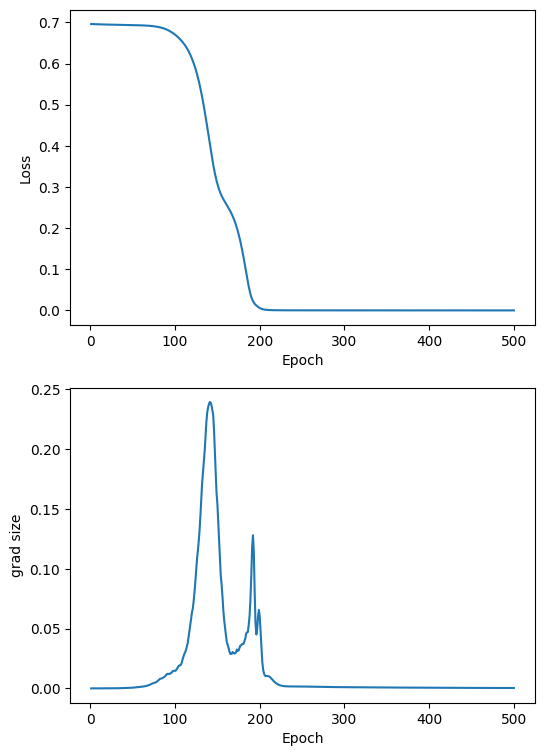

In [16]:
plt.figure(figsize=(6,9)) # 내 필기용
plt.subplot(2,1,1) # 내 필기용
plt.plot(range(1,EPOCH+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(2,1,2) # 내 필기용
plt.plot(range(1,EPOCH+1), grad_history) # 내 필기용
plt.xlabel("Epoch") # 내 필기용
plt.ylabel("grad size") # 내 필기용

In [17]:
# 여기는 SGD로 바꺼본 것 (내 필기용)
# from torch import optim
# import torch.nn.functional as F
# import random

# LR = 1e-2 # case 2, very deep
# EPOCH = 100 # case 2, very deep

# model=MLP()
# optimizer = optim.SGD(model.parameters(), lr=LR)

# loss_history=[]
# grad_history=[]
# update_size_history=[]

# model.train()

# shuffle_idx=list(range(N))
# random.shuffle(shuffle_idx)
# for ep in range(EPOCH):
#     for i in shuffle_idx:
#         # inference
#         y_hat = model(torch.unsqueeze(X[i,:],dim=0))
#         # cross entropy loss
#         loss = F.binary_cross_entropy(y_hat, torch.unsqueeze(y[i],dim=0))
#         # prev weights
#         prev=model.MLP[0].weight.detach().clone()
#         # update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # update amount
#     grad_history += [ torch.sum(torch.abs( model.MLP[0].weight.grad )).item() ]
#     update_size_history += [ torch.sum(torch.abs( model.MLP[0].weight.detach() - prev)).item() ]
#     # print loss
#     loss_history += [loss.item()]
#     print(f"Epoch: {ep+1}, train loss: {round(loss.item(),3)}")
#     print("-"*20)]
#
# plt.figure(figsize=(6,9))
# plt.subplot(2,1,1)
# plt.plot(range(1,EPOCH+1),loss_history)
# plt.ylabel("loss")
# plt.subplot(2,1,2)
# plt.plot(range(1,EPOCH+1),grad_history)
# plt.ylabel("grad_size")

## STEP 4. 모델 테스트하기

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'x2')

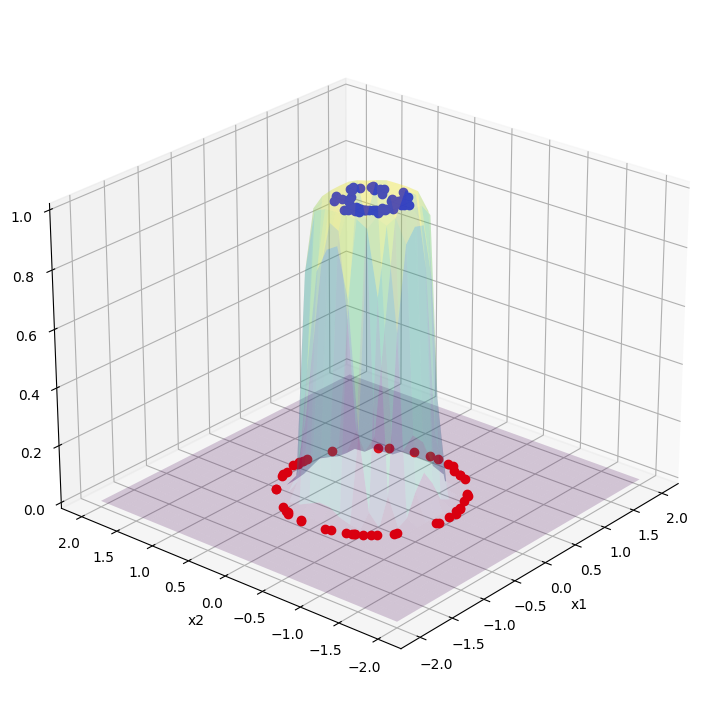

In [18]:
# from matplotlib.colors import LightSource # 내 필기용

# x1_test=torch.linspace(-10,10,30) # case 1
# x2_test=torch.linspace(-10,10,30) # case 1
x1_test=torch.linspace(-2,2,30) # case 2
x2_test=torch.linspace(-2,2,30) # case 2
X1_test, X2_test=torch.meshgrid(x1_test,x2_test)
X_test=torch.cat([X1_test.unsqueeze(dim=2), X2_test.unsqueeze(dim=2)], dim=2)

model.eval() # test mode로 # 1. 해결
with torch.no_grad(): # 2. 해결
    y_hat=model(X_test)
# 1. dropout 혹은 BN 같은거 사용했다면 train mode와 test mode 동작이 다르므로 eval()로 mode를 바꿔줘야
# 2. grad_fn 계산 <- 메모리가 불필요하게 쓰인다
Y_hat = y_hat.squeeze()

# print(model.training)
# model.train()
# print(model.training)

plt.figure(figsize=[10, 9]) # figsize=[가로, 세로]
ax = plt.axes(projection="3d")
ax.view_init(elev=25,azim=-140)
# ls = LightSource(azdeg=45, altdeg=30) # 내 필기용
# rgb = ls.shade(Y_hat.numpy(), plt.cm.RdYlBu) # 내 필기용
# ax.plot_surface(X1_test,X2_test,Y_hat.numpy(), facecolors=rgb, alpha=0.2) # 내 필기용
ax.plot_surface(X1_test,X2_test,Y_hat.numpy(), cmap="viridis", alpha=0.2)
plt.plot(class1_data[:,0],class1_data[:,1],class1_label.squeeze(),'bo')
plt.plot(class2_data[:,0],class2_data[:,1],class2_label.squeeze(),'ro')
plt.xlabel("x1")
plt.ylabel("x2")

In [19]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=X1_test, y=X2_test, z=Y_hat, colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='binary classification', width=700, height=600)